In [1]:
# Cargando las librerias necesarias para el proyecto
import numpy as np
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(1)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
%matplotlib inline
import os
import shutil
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

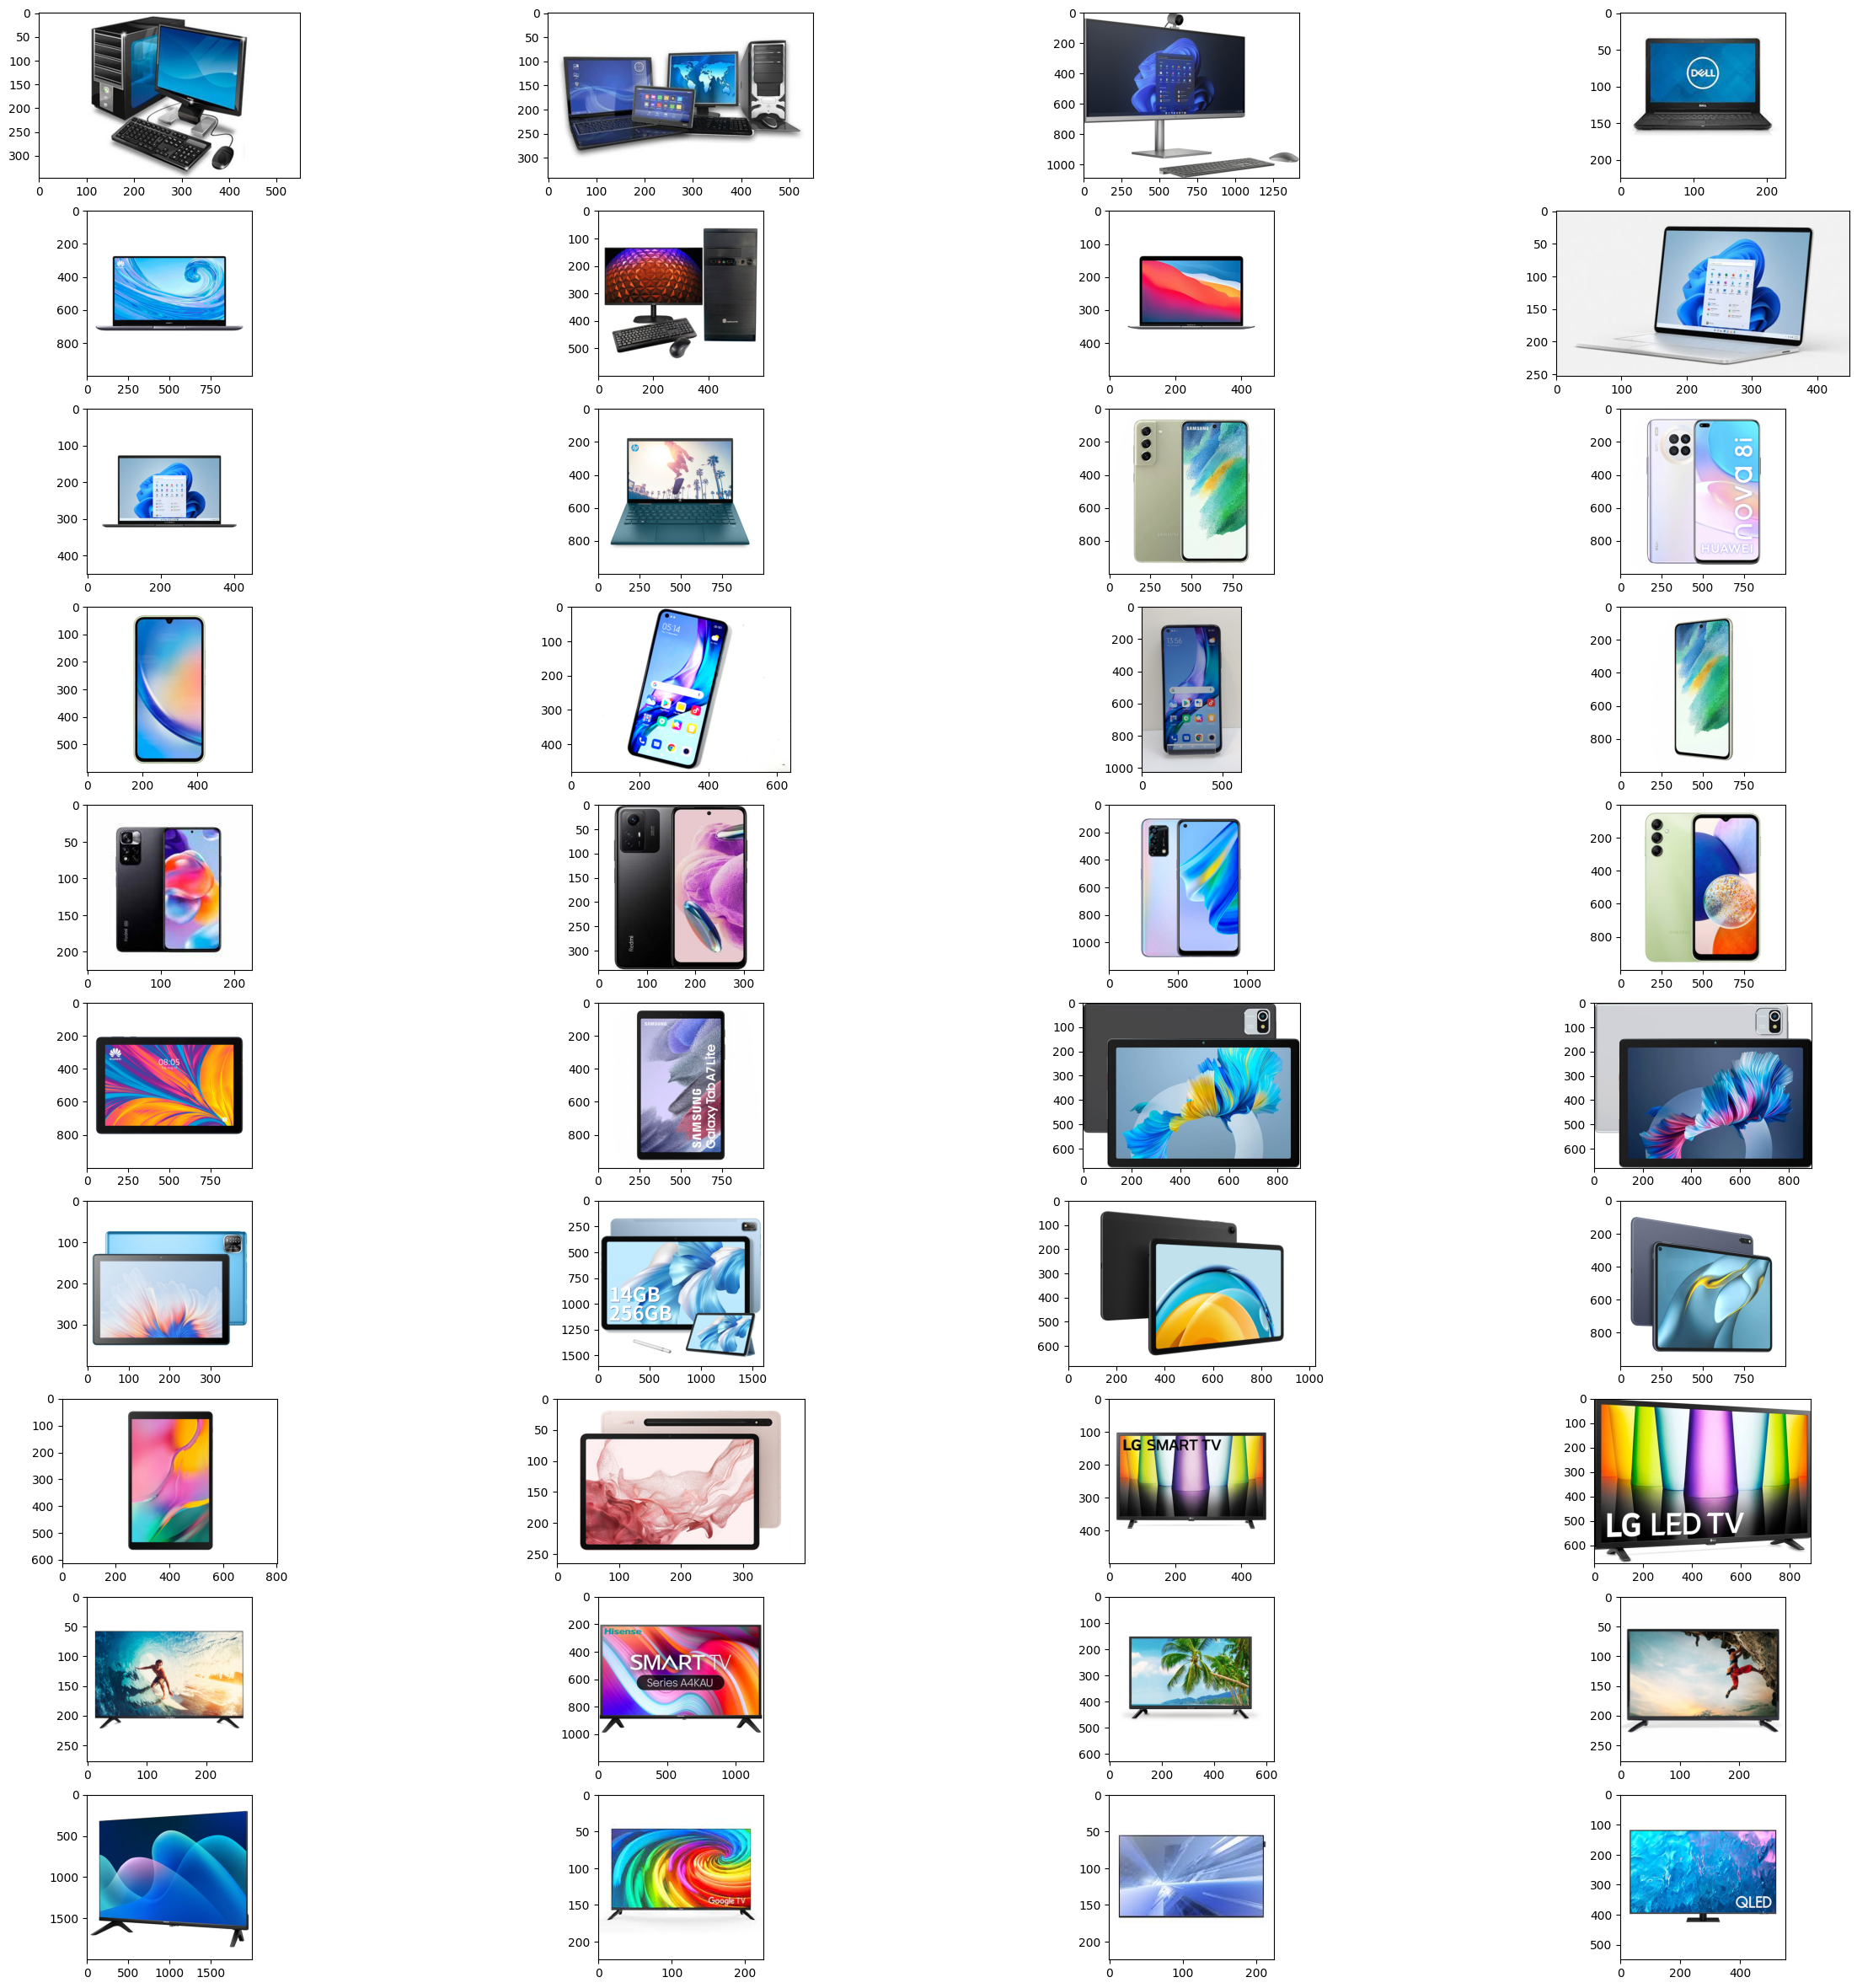

In [2]:


# Cargando los datos
modelpath = "./models/"
dataset = "./dataset/images/"
train_path = dataset + "train/"
test_path = dataset + "test/"

# Cambiar segun cantidad de datos
train_length = 640
# train_length = train_length + 1
test_length = 120
# test_length = test_length + 1

# Visualizando las imagenes de entrenaiento
plt.figure(figsize=(30, 30))
for i in range(1, 41):
    plt.subplot(10, 4, i)
    plt.imshow(imread(train_path+"image"+str(i) + ".jpeg"))

plt.show()

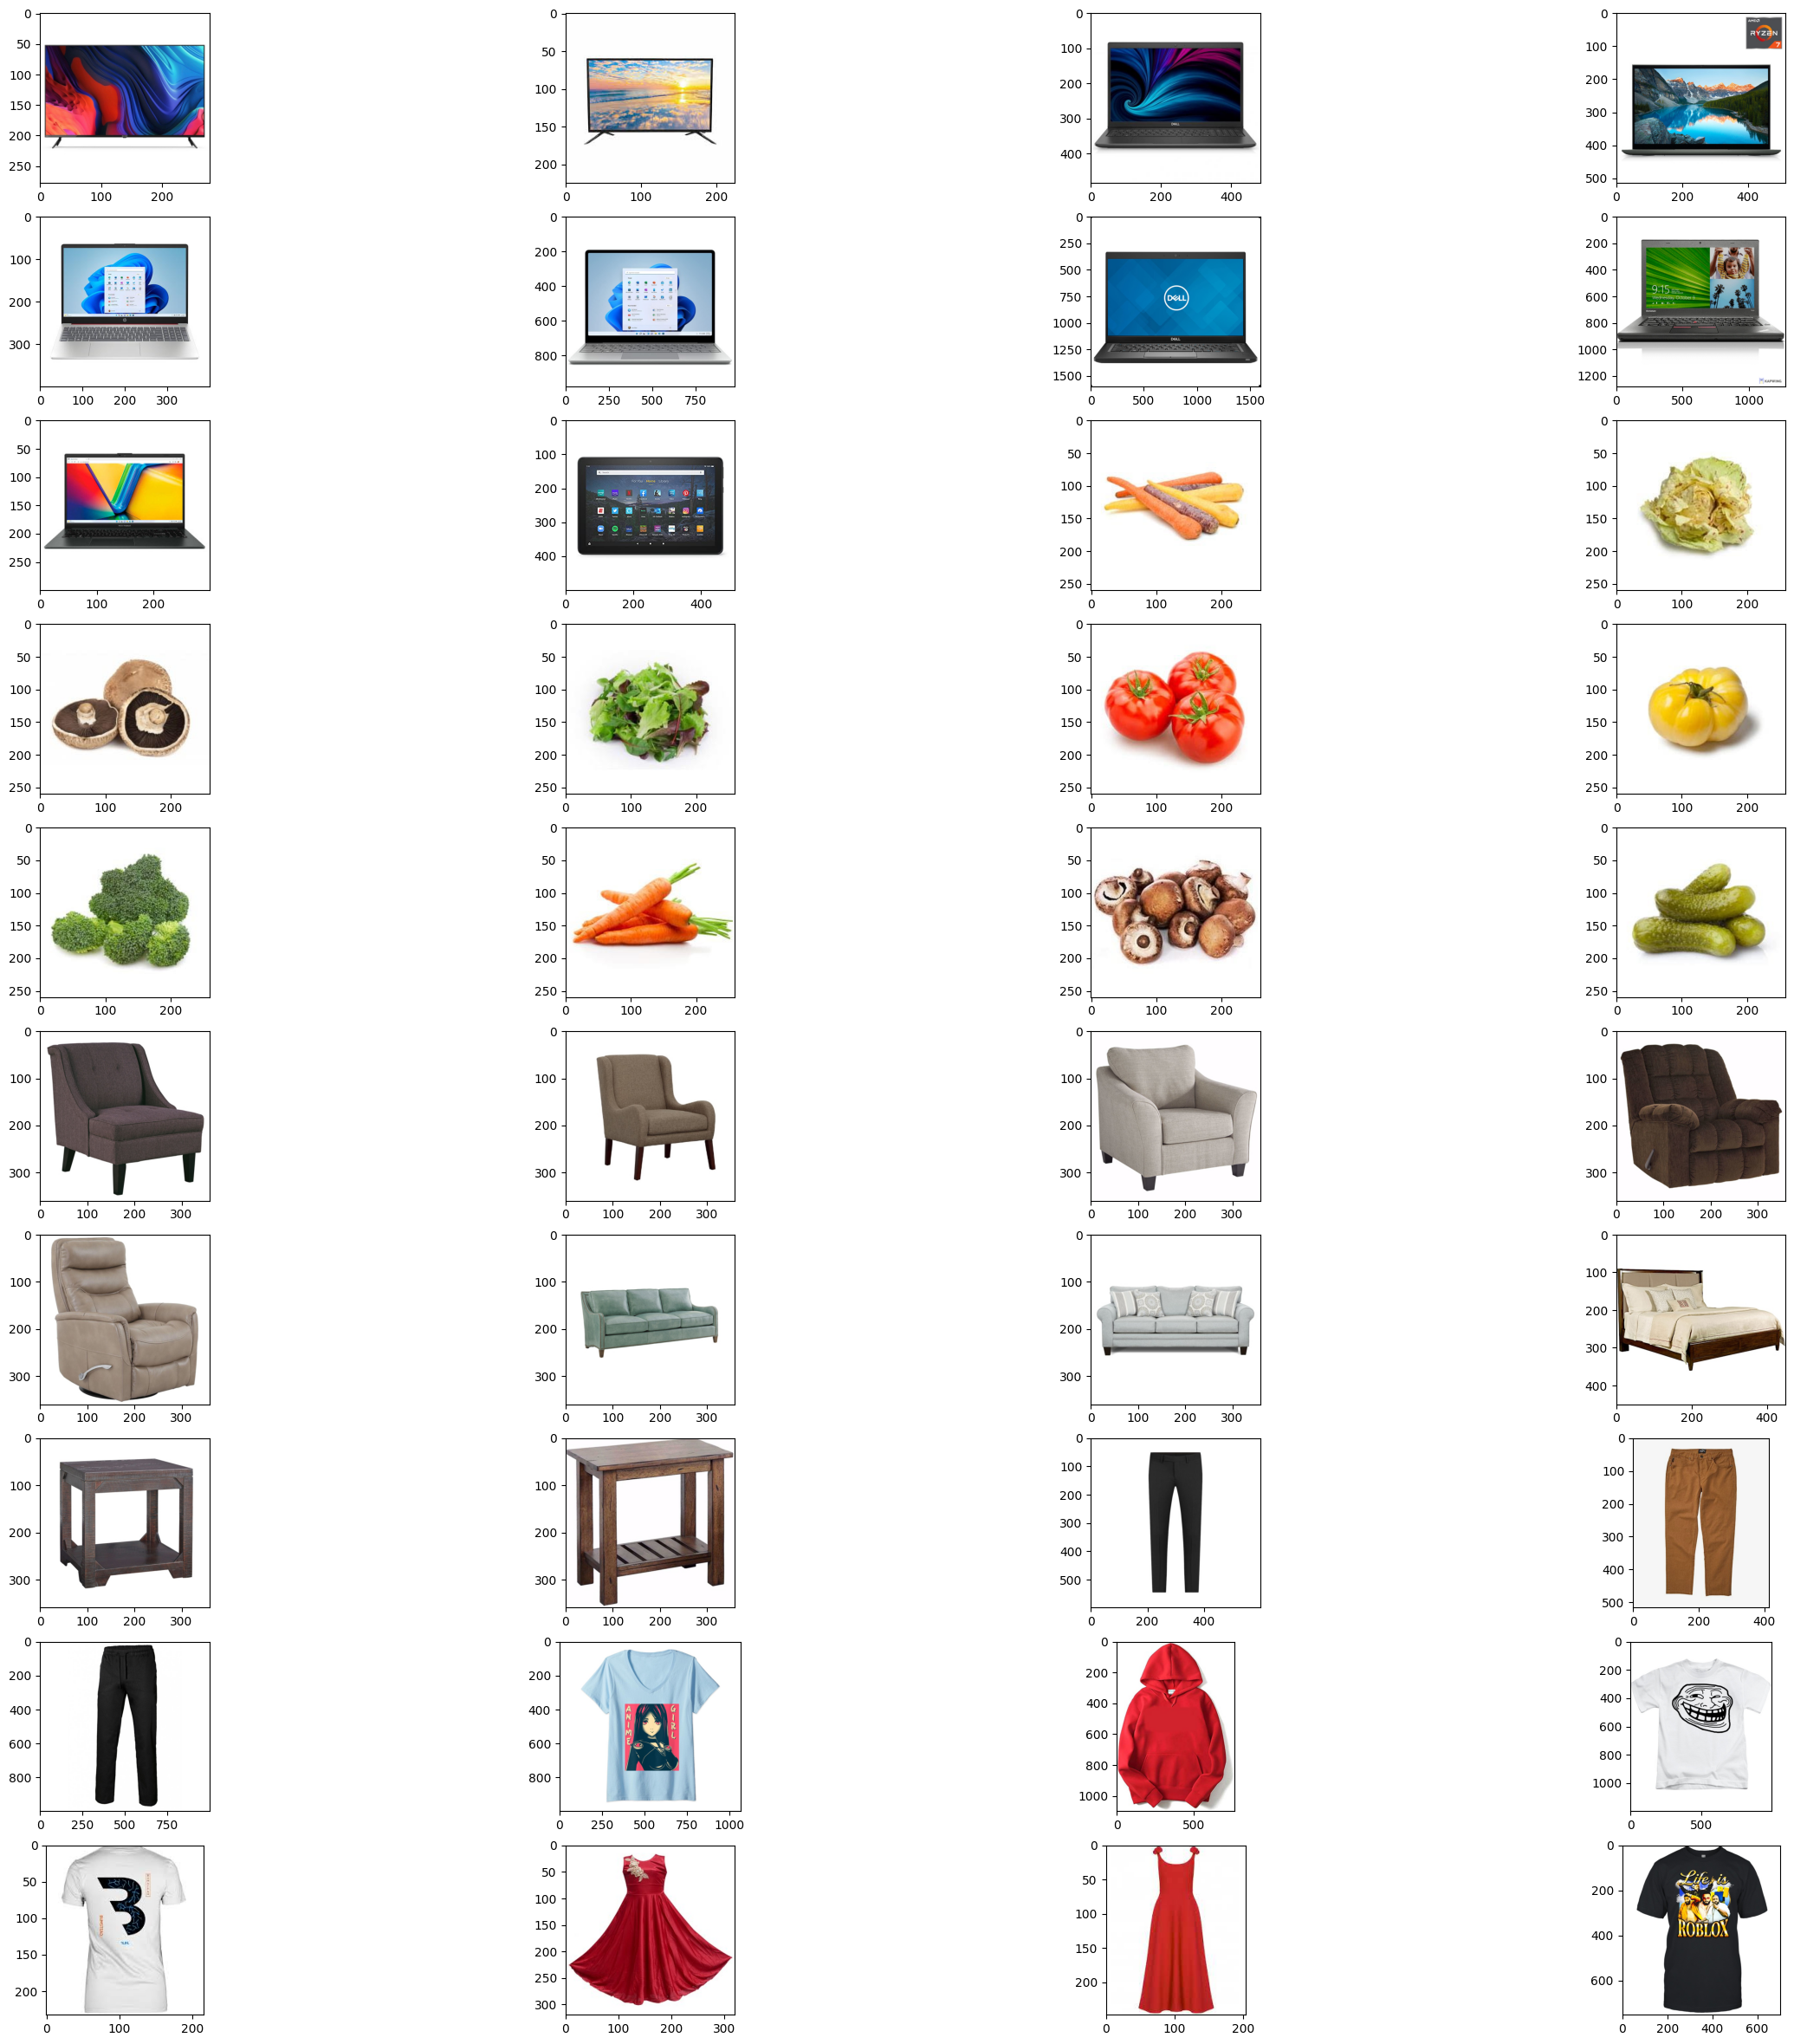

In [3]:
# Visualizando las imagenes de prueba
plt.figure(figsize=(30, 30))
for i in range(1, 41):
    plt.subplot(10, 4, i)
    plt.imshow(imread(test_path+"test_image"+str(i) + ".jpeg"))

plt.show()

In [4]:
df_train = pd.read_csv("./dataset/train.csv")
df_test = pd.read_csv("./dataset/test.csv")

In [5]:
labels=[0,1,2,3]
for i in range(len(labels)):
    label = str(i)
    try:
        os.mkdir(train_path + label)
        os.mkdir(test_path + label)
    except OSError:
        pass

In [6]:
# Copiando las imagenes a sus respectivas carpetas
def image_copy(df, path):
    for i in tqdm(range(len(df["name"]))):
        img = df["name"].iloc[i]
        if(df["category"].iloc[i]==0):
            shutil.copy(path+img+".jpeg",path+"0")
        elif(df["category"].iloc[i]==1):
            shutil.copy(path+img+".jpeg",path+"1")
        elif(df["category"].iloc[i]==2):
            shutil.copy(path+img+".jpeg",path+"2")
        elif(df["category"].iloc[i]==3):
            shutil.copy(path+img+".jpeg",path+"3")
    
    print("\nCopiado de imagenes completado para la carpeta: ", path)

image_copy(df_train, train_path)
image_copy(df_test, test_path)

100%|██████████| 640/640 [00:01<00:00, 430.61it/s]



Copiado de imagenes completado para la carpeta:  ./dataset/images/train/


100%|██████████| 120/120 [00:00<00:00, 558.11it/s]


Copiado de imagenes completado para la carpeta:  ./dataset/images/test/


In [7]:
categories = {
    "0": "Tecnologia",
    "1": "Alimentos",
    "2": "Mobiliario",
    "3": "Prendas"
}

In [8]:
df_train["category"] = df_train["category"].astype(str)
df_test["category"] = df_test["category"].astype(str)

In [9]:
# Reemplazando los valores de las categorias por su nombre
df_train["category"] = df_train["category"].replace(categories)
df_test["category"] = df_test["category"].replace(categories)

In [10]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix

In [41]:
# Promedios de largo y ancho de las imagenes
width = []
height = []
for i in range(1, train_length+1):
    img = imread(train_path+"image"+str(i)+".jpeg")
    width.append(img.shape[0])
    height.append(img.shape[1])

# Calculando el promedio de largo y ancho de las imagenes
avg_width = np.mean(width)
avg_height = np.mean(height)

imgSize = (int(avg_width), int(avg_height))


test_datagen = ImageDataGenerator(rescale = 1/255)
                                                 

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size=imgSize,
                                            batch_size=1,
                                            class_mode='categorical'
                                            shuffle=False)


c:\Users\Andrès DLR\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Found 120 images belonging to 4 classes.


In [42]:
from sklearn.metrics import confusion_matrix
import numpy as np
labels = ["Technology", "Food", "Furniture", "Clothes"]

In [43]:
# Import GradCAM and SmoothGrad
from tf_explain.core.grad_cam import GradCAM
from tf_explain.core.smoothgrad import SmoothGrad



## Model1 

10/10 [==============================] - 4s 323ms/step
Accuracy: 0.2000
Misclass: 0.8000


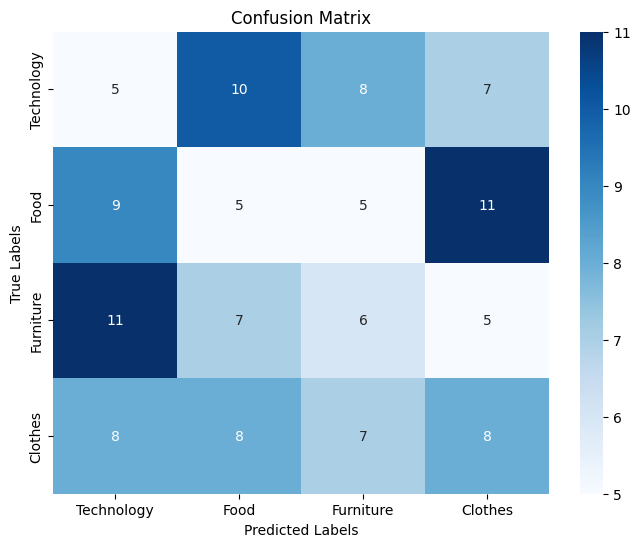

In [44]:

model1 = load_model(modelpath + 'iter_2_model1.keras')
# Assuming 'model' is your trained model and 'test_set' is your test data generator

# Calculate the number of steps per epoch for the test set
test_steps_per_epoch = np.math.ceil(test_set.samples / test_set.batch_size)

# Make predictions on the test set
predictions = model1.predict(test_set, steps=test_steps_per_epoch)

# Convert predictions to class indices
predicted_classes = np.argmax(predictions, axis=1)


true_classes = test_set.classes

# Generate confusion matrix
conf_matrix_1 = confusion_matrix(y_pred=predicted_classes, y_true=true_classes)


# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_1, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)

# Add labels and title
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix')
accuracy = np.trace(conf_matrix_1) / float(np.sum(conf_matrix_1))
misclass = 1 - accuracy
print('Accuracy: {:.4f}'.format(accuracy))
print('Misclass: {:.4f}'.format(misclass))

# Show the plot
plt.show()

Text(0.5, 1.0, 'GradCAM Modelo 1')

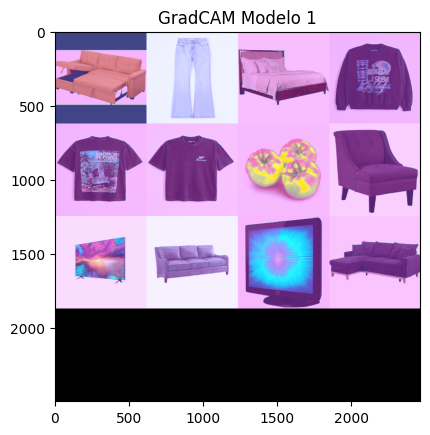

In [46]:
# Using GradCAM for model 1

img, label = test_set[10]

layer_name = "conv2d_4"

explainer = GradCAM()

grad_cam = explainer.explain((img, None), model1, class_index=0, layer_name=layer_name)

# Show results
plt.imshow(grad_cam, cmap="viridis")
plt.title('GradCAM Modelo 1')


Text(0.5, 1.0, 'GradCAM Modelo 1')

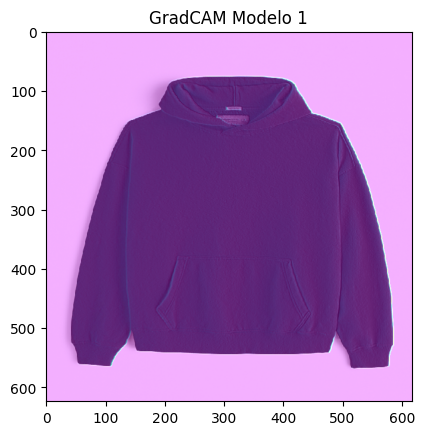

In [ ]:
img, label = test_set[12]

layer_name = "conv2d_4"

explainer = GradCAM()

grad_cam = explainer.explain((img, None), model1, class_index=0, layer_name=layer_name)

# Show results
plt.imshow(grad_cam, cmap="viridis")
plt.title('GradCAM Modelo 1')

Text(0.5, 1.0, 'GradCAM Modelo 1')

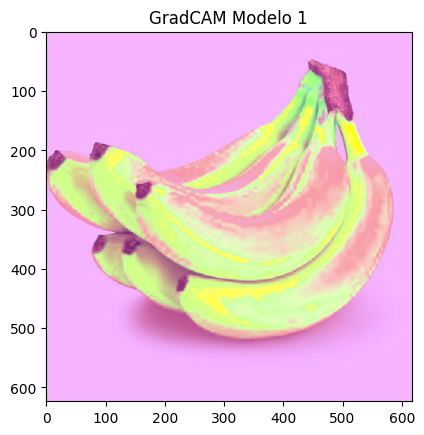

In [ ]:
img, label = test_set[11]

layer_name = "conv2d_4"

explainer = GradCAM()

grad_cam = explainer.explain((img, None), model1, class_index=0, layer_name=layer_name)

# Show results
plt.imshow(grad_cam, cmap="viridis")
plt.title('GradCAM Modelo 1')

Text(0.5, 1.0, 'GradCAM Modelo 1')

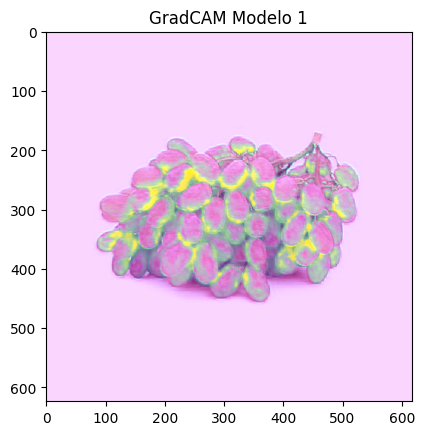

In [ ]:
img, label = test_set[31]

layer_name = "conv2d_4"

explainer = GradCAM()

grad_cam = explainer.explain((img, None), model1, class_index=0, layer_name=layer_name)

# Show results
plt.imshow(grad_cam, cmap="viridis")
plt.title('GradCAM Modelo 1')

### Model 2


120/120 [==============================] - 11s 93ms/step
Accuracy: 0.2083
Misclass: 0.7917


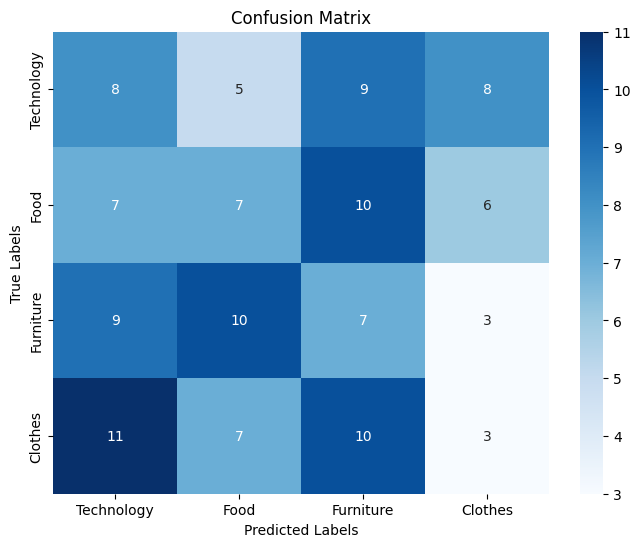

In [ ]:

model2 = load_model(modelpath + 'iter_2_model2.keras')
# Assuming 'model' is your trained model and 'test_set' is your test data generator

# Calculate the number of steps per epoch for the test set
test_steps_per_epoch = np.math.ceil(test_set.samples / test_set.batch_size)

# Make predictions on the test set
predictions = model2.predict(test_set, steps=test_steps_per_epoch)

# Convert predictions to class indices
predicted_classes = np.argmax(predictions, axis=1)


true_classes = test_set.classes

# Generate confusion matrix
conf_matrix_2 = confusion_matrix(true_classes, predicted_classes)


# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_2, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)

# Add labels and title
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix')

accuracy = np.trace(conf_matrix_2) / float(np.sum(conf_matrix_2))
misclass = 1 - accuracy
print('Accuracy: {:.4f}'.format(accuracy))
print('Misclass: {:.4f}'.format(misclass))

# Show the plot
plt.show()

Text(0.5, 1.0, 'GradCAM Modelo 2')

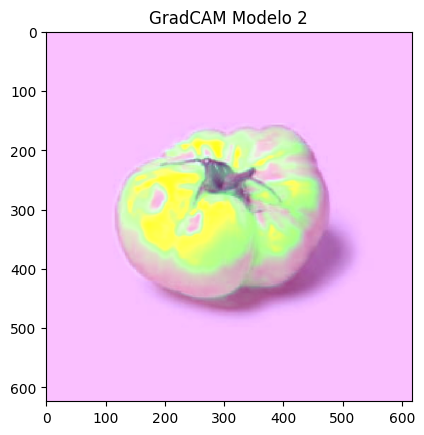

In [ ]:
# Using GradCAM for model 2

img, label = test_set[10]

layer_name = "conv2d_6"

explainer = GradCAM()

grad_cam = explainer.explain((img, None), model2, class_index=0, layer_name=layer_name)

# Show results
plt.imshow(grad_cam)
plt.title('GradCAM Modelo 2')

Text(0.5, 1.0, 'GradCAM Modelo 2')

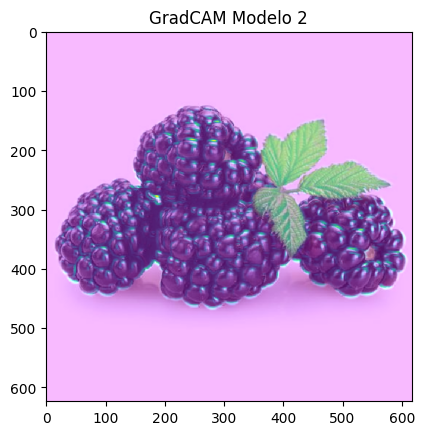

In [ ]:
# Using GradCAM for model 2

img, label = test_set[12]

layer_name = "conv2d_6"

explainer = GradCAM()

grad_cam = explainer.explain((img, None), model2, class_index=0, layer_name=layer_name)

# Show results
plt.imshow(grad_cam)
plt.title('GradCAM Modelo 2')

Text(0.5, 1.0, 'GradCAM Modelo 2')

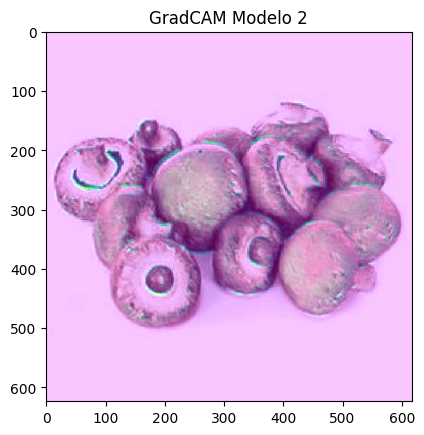

In [ ]:
# Using GradCAM for model 2

img, label = test_set[11]

layer_name = "conv2d_6"

explainer = GradCAM()

grad_cam = explainer.explain((img, None), model2, class_index=0, layer_name=layer_name)

# Show results
plt.imshow(grad_cam)
plt.title('GradCAM Modelo 2')

Text(0.5, 1.0, 'GradCAM Modelo 2')

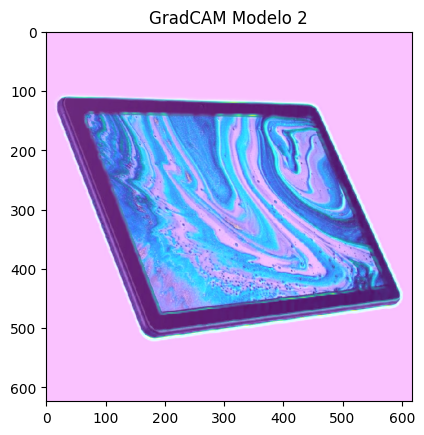

In [ ]:
# Using GradCAM for model 2

img, label = test_set[31]

layer_name = "conv2d_6"

explainer = GradCAM()

grad_cam = explainer.explain((img, None), model2, class_index=0, layer_name=layer_name)

# Show results
plt.imshow(grad_cam)
plt.title('GradCAM Modelo 2')

## Model 3

120/120 [==============================] - 10s 81ms/step
Accuracy: 0.2417
Misclass: 0.7583


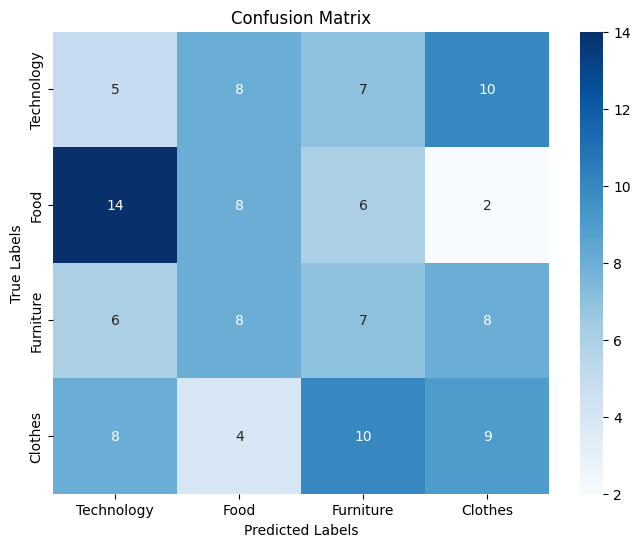

In [ ]:

model3 = load_model(modelpath + 'iter_2_model3.keras')
# Assuming 'model' is your trained model and 'test_set' is your test data generator

# Calculate the number of steps per epoch for the test set
test_steps_per_epoch = np.math.ceil(test_set.samples / test_set.batch_size)

# Make predictions on the test set
predictions = model3.predict(test_set, steps=test_steps_per_epoch)

# Convert predictions to class indices
predicted_classes = np.argmax(predictions, axis=1)


true_classes = test_set.classes

# Generate confusion matrix
conf_matrix_3 = confusion_matrix(true_classes, predicted_classes)


# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_3, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)

# Add labels and title
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix')

accuracy = np.trace(conf_matrix_3) / float(np.sum(conf_matrix_3))
misclass = 1 - accuracy
print('Accuracy: {:.4f}'.format(accuracy))
print('Misclass: {:.4f}'.format(misclass))

# Show the plot
plt.show()

Text(0.5, 1.0, 'GradCAM Modelo 3')

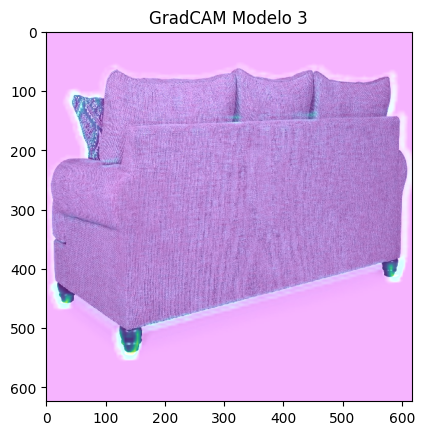

In [ ]:
# Using GradCAM for model 3

img, label = test_set[10]

layer_name = "conv2d_9"

explainer = GradCAM()

grad_cam = explainer.explain((img, None), model3, class_index=0, layer_name=layer_name)

# Show results
plt.imshow(grad_cam)
plt.title('GradCAM Modelo 3')

Text(0.5, 1.0, 'GradCAM Modelo 3')

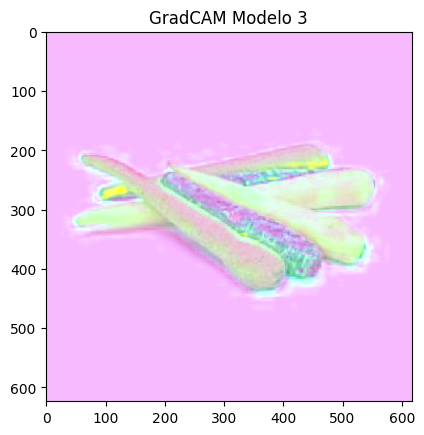

In [ ]:
# Using GradCAM for model 3

img, label = test_set[12]

layer_name = "conv2d_9"

explainer = GradCAM()

grad_cam = explainer.explain((img, None), model3, class_index=0, layer_name=layer_name)

# Show results
plt.imshow(grad_cam)
plt.title('GradCAM Modelo 3')

Text(0.5, 1.0, 'GradCAM Modelo 3')

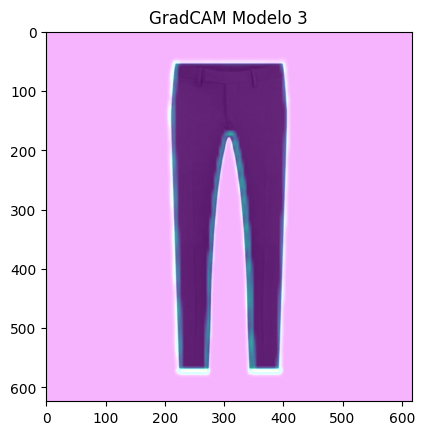

In [ ]:
# Using GradCAM for model 3

img, label = test_set[11]

layer_name = "conv2d_9"

explainer = GradCAM()

grad_cam = explainer.explain((img, None), model3, class_index=0, layer_name=layer_name)

# Show results
plt.imshow(grad_cam)
plt.title('GradCAM Modelo 3')

Text(0.5, 1.0, 'GradCAM Modelo 3')

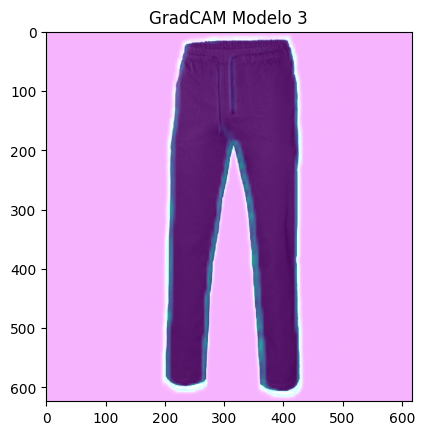

In [ ]:
# Using GradCAM for model 3

img, label = test_set[31]

layer_name = "conv2d_9"

explainer = GradCAM()

grad_cam = explainer.explain((img, None), model3, class_index=0, layer_name=layer_name)

# Show results
plt.imshow(grad_cam)
plt.title('GradCAM Modelo 3')

## Model 4 Resnet


120/120 [==============================] - 46s 376ms/step
Accuracy: 0.2833
Misclass: 0.7167


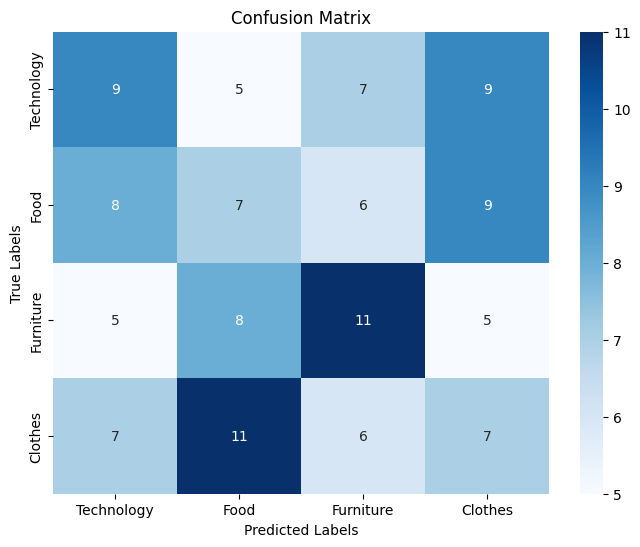

In [ ]:

model4 = load_model(modelpath + 'iter_2_model4.keras')
# Assuming 'model' is your trained model and 'test_set' is your test data generator

# Calculate the number of steps per epoch for the test set
test_steps_per_epoch = np.math.ceil(test_set.samples / test_set.batch_size)

# Make predictions on the test set
predictions = model4.predict(test_set, steps=test_steps_per_epoch)

# Convert predictions to class indices
predicted_classes = np.argmax(predictions, axis=1)


true_classes = test_set.classes

# Generate confusion matrix
conf_matrix_4 = confusion_matrix(true_classes, predicted_classes)


# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_4, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)

# Add labels and title
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix')

accuracy = np.trace(conf_matrix_4) / float(np.sum(conf_matrix_4))
misclass = 1 - accuracy
print('Accuracy: {:.4f}'.format(accuracy))
print('Misclass: {:.4f}'.format(misclass))

# Show the plot
plt.show()

Text(0.5, 1.0, 'GradCAM Modelo 4')

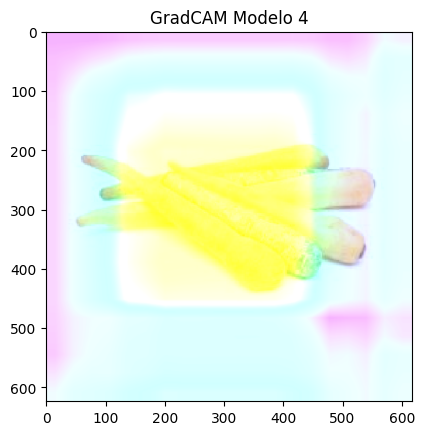

In [ ]:
img, label = test_set[10]

layer_name = "conv5_block3_3_conv"

explainer = GradCAM()

grad_cam = explainer.explain((img, None), model4, class_index=0, layer_name=layer_name)

# Show results
plt.imshow(grad_cam)
plt.title('GradCAM Modelo 4')

c:\Users\Andrès DLR\AppData\Local\Programs\Python\Python310\lib\site-packages\tf_explain\utils\display.py:112: RuntimeWarning: invalid value encountered in divide
  heatmap = (heatmap - np.min(heatmap)) / (heatmap.max() - heatmap.min())


Text(0.5, 1.0, 'GradCAM Modelo 4')

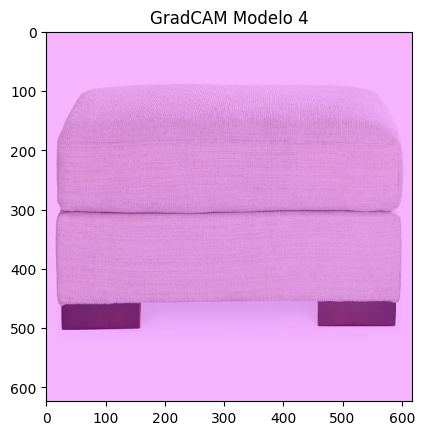

In [ ]:
img, label = test_set[12]

layer_name = "conv5_block3_3_conv"

explainer = GradCAM()

grad_cam = explainer.explain((img, None), model4, class_index=0, layer_name=layer_name)

# Show results
plt.imshow(grad_cam)
plt.title('GradCAM Modelo 4')

Text(0.5, 1.0, 'GradCAM Modelo 4')

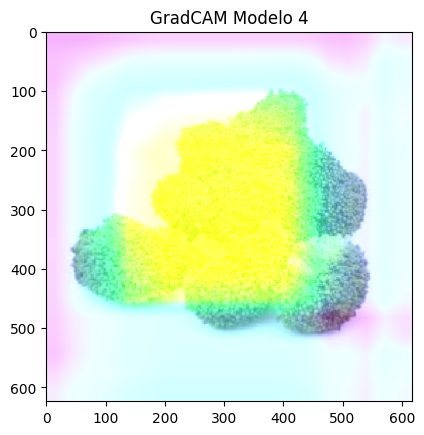

In [ ]:
img, label = test_set[11]

layer_name = "conv5_block3_3_conv"

explainer = GradCAM()

grad_cam = explainer.explain((img, None), model4, class_index=0, layer_name=layer_name)

# Show results
plt.imshow(grad_cam)
plt.title('GradCAM Modelo 4')

Text(0.5, 1.0, 'GradCAM Modelo 4')

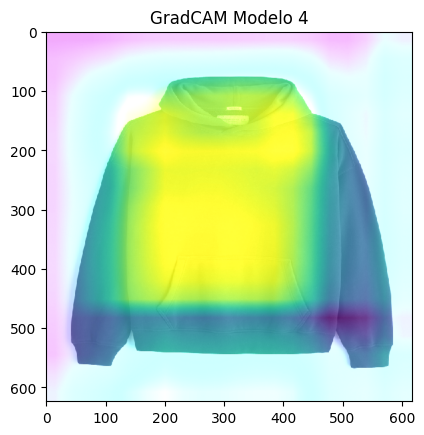

In [ ]:
img, label = test_set[31]

layer_name = "conv5_block3_3_conv"

explainer = GradCAM()

grad_cam = explainer.explain((img, None), model4, class_index=0, layer_name=layer_name)

# Show results
plt.imshow(grad_cam)
plt.title('GradCAM Modelo 4')

## Modelos con 50 epochs

### Modelo 2

In [ ]:
model_cnn_2 = load_model(modelpath + 'model_cnn_2.keras')

# Calculate the number of steps per epoch for the test set
test_steps_per_epoch = np.math.ceil(test_set.samples / test_set.batch_size)

# Make predictions on the test set
predictions = model_cnn_2.predict(test_set, steps=test_steps_per_epoch)

# Convert predictions to class indices
predicted_classes = np.argmax(predictions, axis=1)


true_classes = test_set.classes

# Generate confusion matrix
conf_matrix_5 = confusion_matrix(true_classes, predicted_classes)


# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_5, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)

# Add labels and title
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix')

accuracy = np.trace(conf_matrix_5) / float(np.sum(conf_matrix_5))
misclass = 1 - accuracy
print('Accuracy: {:.4f}'.format(accuracy))
print('Misclass: {:.4f}'.format(misclass))

# Show the plot
plt.show()

InvalidArgumentError: Graph execution error:

Detected at node 'sequential/dense/Relu' defined at (most recent call last):
    File "c:\Users\Andrès DLR\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\Andrès DLR\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\Andrès DLR\AppData\Roaming\Python\Python310\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\Andrès DLR\AppData\Roaming\Python\Python310\site-packages\traitlets\config\application.py", line 1041, in launch_instance
      app.start()
    File "C:\Users\Andrès DLR\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelapp.py", line 724, in start
      self.io_loop.start()
    File "C:\Users\Andrès DLR\AppData\Roaming\Python\Python310\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\Andrès DLR\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 600, in run_forever
      self._run_once()
    File "c:\Users\Andrès DLR\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1896, in _run_once
      handle._run()
    File "c:\Users\Andrès DLR\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Andrès DLR\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "C:\Users\Andrès DLR\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "C:\Users\Andrès DLR\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 408, in dispatch_shell
      await result
    File "C:\Users\Andrès DLR\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "C:\Users\Andrès DLR\AppData\Roaming\Python\Python310\site-packages\ipykernel\ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "C:\Users\Andrès DLR\AppData\Roaming\Python\Python310\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\Andrès DLR\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 2945, in run_cell
      result = self._run_cell(
    File "C:\Users\Andrès DLR\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3000, in _run_cell
      return runner(coro)
    File "C:\Users\Andrès DLR\AppData\Roaming\Python\Python310\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\Andrès DLR\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3203, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\Andrès DLR\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3382, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\Andrès DLR\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3442, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Andrès DLR\AppData\Local\Temp\ipykernel_13180\2513193354.py", line 7, in <module>
      predictions = model_cnn_2.predict(test_set, steps=test_steps_per_epoch)
    File "c:\Users\Andrès DLR\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Andrès DLR\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 2554, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "c:\Users\Andrès DLR\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 2341, in predict_function
      return step_function(self, iterator)
    File "c:\Users\Andrès DLR\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 2327, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Andrès DLR\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 2315, in run_step
      outputs = model.predict_step(data)
    File "c:\Users\Andrès DLR\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 2283, in predict_step
      return self(x, training=False)
    File "c:\Users\Andrès DLR\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Andrès DLR\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\Andrès DLR\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Andrès DLR\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Andrès DLR\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Andrès DLR\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\sequential.py", line 405, in call
      return super().call(inputs, training=training, mask=mask)
    File "c:\Users\Andrès DLR\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\Andrès DLR\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\Andrès DLR\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Andrès DLR\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Andrès DLR\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Andrès DLR\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py", line 255, in call
      outputs = self.activation(outputs)
    File "c:\Users\Andrès DLR\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\activations.py", line 321, in relu
      return backend.relu(
    File "c:\Users\Andrès DLR\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\backend.py", line 5397, in relu
      x = tf.nn.relu(x)
Node: 'sequential/dense/Relu'
Matrix size-incompatible: In[0]: [1,1498112], In[1]: [1959744,64]
	 [[{{node sequential/dense/Relu}}]] [Op:__inference_predict_function_17519]

Text(0.5, 1.0, 'GradCAM Modelo 2 con 50 epochs')

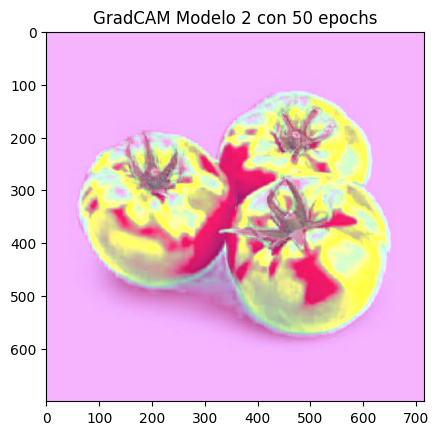

In [ ]:
img, label = test_set[10]

layer_name = "conv2d_1"

explainer = GradCAM()

grad_cam = explainer.explain((img, None), model_cnn_2, class_index=0, layer_name=layer_name)

# Show results
plt.imshow(grad_cam)
plt.title('GradCAM Modelo 2 con 50 epochs')

Text(0.5, 1.0, 'GradCAM Modelo 2 con 50 epochs')

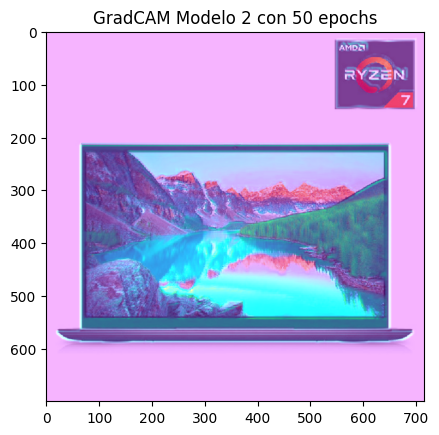

In [ ]:
img, label = test_set[12]

layer_name = "conv2d_1"

explainer = GradCAM()

grad_cam = explainer.explain((img, None), model_cnn_2, class_index=0, layer_name=layer_name)

# Show results
plt.imshow(grad_cam)
plt.title('GradCAM Modelo 2 con 50 epochs')

Text(0.5, 1.0, 'GradCAM Modelo 2 con 50 epochs')

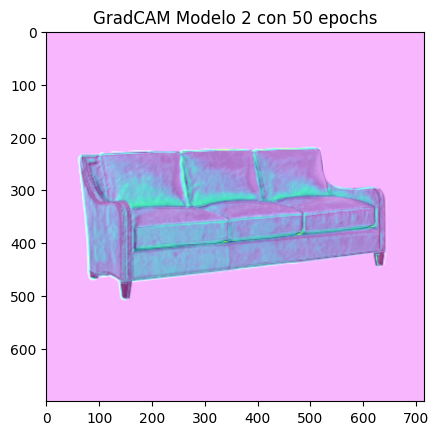

In [ ]:
img, label = test_set[11]

layer_name = "conv2d_1"

explainer = GradCAM()

grad_cam = explainer.explain((img, None), model_cnn_2, class_index=0, layer_name=layer_name)

# Show results
plt.imshow(grad_cam)
plt.title('GradCAM Modelo 2 con 50 epochs')

Text(0.5, 1.0, 'GradCAM Modelo 2 con 50 epochs')

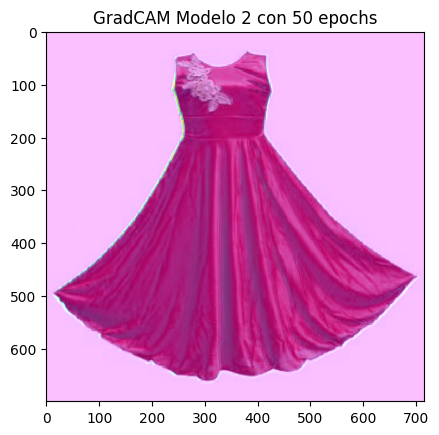

In [ ]:
img, label = test_set[31]

layer_name = "conv2d_1"

explainer = GradCAM()

grad_cam = explainer.explain((img, None), model_cnn_2, class_index=0, layer_name=layer_name)

# Show results
plt.imshow(grad_cam)
plt.title('GradCAM Modelo 2 con 50 epochs')

### Modelo 4 - Resnet

40/40 [==============================] - 20s 493ms/step
Accuracy: 0.2000
Misclass: 0.8000


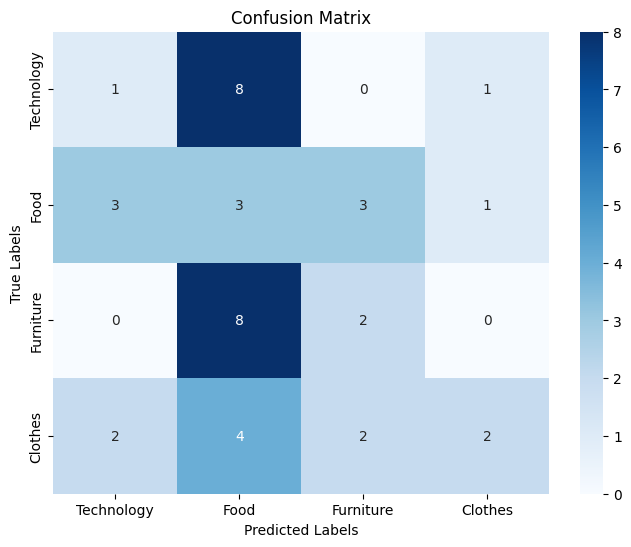

In [ ]:
resnet_model = load_model(modelpath + 'resnet_model.keras')

# Calculate the number of steps per epoch for the test set
test_steps_per_epoch = np.math.ceil(test_set.samples / test_set.batch_size)

# Make predictions on the test set
predictions = model4.predict(test_set, steps=test_steps_per_epoch)

# Convert predictions to class indices
predicted_classes = np.argmax(predictions, axis=1)


true_classes = test_set.classes

# Generate confusion matrix
conf_matrix_6 = confusion_matrix(true_classes, predicted_classes)


# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_6, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)

# Add labels and title
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix')

accuracy = np.trace(conf_matrix_6) / float(np.sum(conf_matrix_6))
misclass = 1 - accuracy
print('Accuracy: {:.4f}'.format(accuracy))
print('Misclass: {:.4f}'.format(misclass))

# Show the plot
plt.show()

Text(0.5, 1.0, 'GradCAM ResNet50')

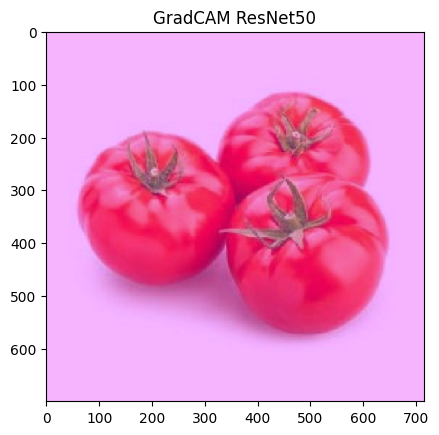

In [ ]:
img, label = test_set[10]

layer_name = "conv5_block3_3_conv"

explainer = GradCAM()

grad_cam = explainer.explain((img, None), resnet_model, class_index=0, layer_name=layer_name)

# Show results
plt.imshow(grad_cam)
plt.title('GradCAM ResNet50')

Text(0.5, 1.0, 'GradCAM ResNet50')

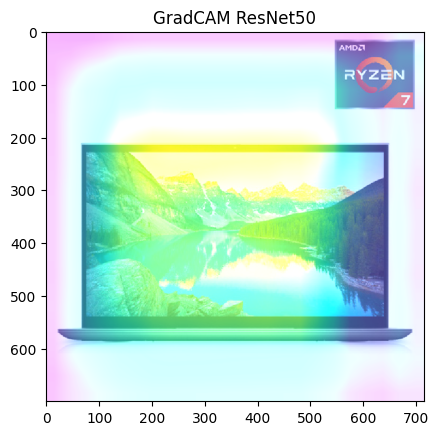

In [ ]:
img, label = test_set[12]

layer_name = "conv5_block3_3_conv"

explainer = GradCAM()

grad_cam = explainer.explain((img, None), resnet_model, class_index=0, layer_name=layer_name)

# Show results
plt.imshow(grad_cam)
plt.title('GradCAM ResNet50')

Text(0.5, 1.0, 'GradCAM ResNet50')

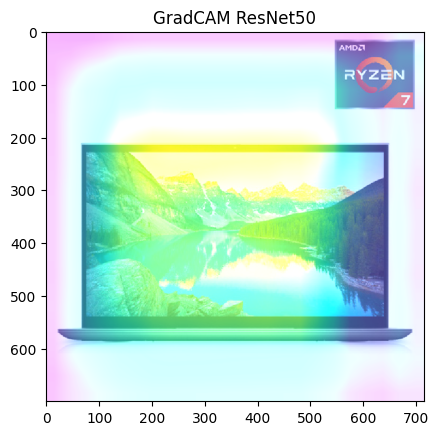

In [ ]:
img, label = test_set[12]

layer_name = "conv5_block3_3_conv"

explainer = GradCAM()

grad_cam = explainer.explain((img, None), resnet_model, class_index=0, layer_name=layer_name)

# Show results
plt.imshow(grad_cam)
plt.title('GradCAM ResNet50')

Text(0.5, 1.0, 'GradCAM ResNet50')

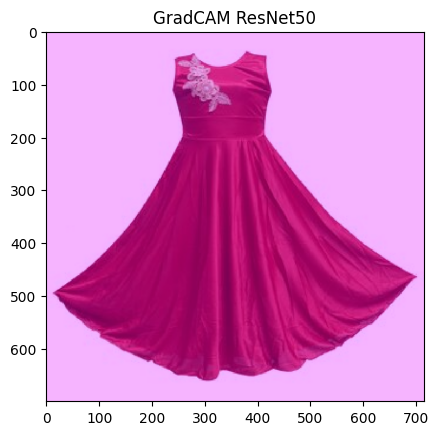

In [ ]:
img, label = test_set[31]

layer_name = "conv5_block3_3_conv"

explainer = GradCAM()

grad_cam = explainer.explain((img, None), resnet_model, class_index=0, layer_name=layer_name)

# Show results
plt.imshow(grad_cam)
plt.title('GradCAM ResNet50')